# Pilot Scan 2 - 6/27/18

## Scan Notes
We collected the following scans that can be found in `.../b2b/data/Raw/Subject002`

* MPRAGE - Anatomical
* 0000 - full run, REST vs finger tapping
* 0001 - short run, REST vs finger tapping
* 0002 - short run, REST vs finger tapping
* 0003 - full run, REST vs imagined tapping
* 0004 - short run, REST vs imagined tapping
* 0005 - short run, REST vs imagined tapping

All functional scans used the same parameters:

* TR: 2sec
* vol dimensions: (64,64,30)
* nTimepts: *full run*-132; *short run*-68  (+ 2 dummy timepts at start of run)

The data from the actual scan session can be found in `.../b2b/pilotScans/pilot2_real`. All offline simulations and testing of different parameters should use the data found in `.../bsb/pilotScans/pilot2_offline`

During the scan session, we:

1. ran a GLM on `0000` that modeled active>0. 
2. Extracted the peak voxel: 28 31 26
3. Build a 5mm sphere around that peak (However, we accidently used the wrong ref volume in building this mask, so it didn't work as expected. Instead, we used the full brain mask from the feat output directory for subsequent steps
4. Ran the `classifyLocalizer.py` script to train and save a classifier. Using whole brain mask, mean classification accuracy was 66%.
5. Loaded the saved classifier into the Pyneal custom analysis script along with whole brain mask. 
6. Ran 2 short runs in real-time. During runs, each volume was classified and the if the prob > 50% a trigger was sent ot the TMS server running up in Guthrie

Two Pyneal runs: `pyneal_021`, `pyneal_022`

We also collected a full run and two short runs using the motor imagery task, but these were not analyzed in real-time

In [4]:
import os
from os.path import join

import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.masking import apply_mask

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
rawDir = '../../data/raw/Subject002/'
rtDir = '../../pilotScans/pilot2_offline/'
timingDir = join(rtDir, 'timingFiles')

# Finger Tapping Analysis
## Raw Activation Plots

In [64]:
def plotRaw(maskFile, runType):
    """ Plot the raw timecourse from the supplied mask
    
    Parameters
    ----------
    maskFile : string
        full path to the mask you want to extract raw signal from
    runType : string {'motor', 'imagery'}
    
    """
    # start the plot
    fig, axs = plt.subplots(3, 1, figsize=(15,10))
    plt.suptitle('{} Activation - {}'.format(runType.capitalize(), os.path.split(maskFile)[-1]), fontsize=24)
    
    # set colors
    if runType == 'motor':
        spanColor = 'dodgerBlue'
        lineColor = 'dodgerBlue'
    elif runType == 'imagery':
        spanColor = 'goldenrod'
        lineColor = 'goldenrod'
        
    # load the mask
    mask = nib.load(maskFile)
    
    # trial times
    restOnsets = np.array([(x*32)+4 for x in range(8)]) 
    activeOnsets = restOnsets + 16
    
    for i, run in enumerate(['0000', '0001', '0002']):
        
        # load and mask the func data
        funcFile = join(rtDir,('func_' + run + '.nii.gz') )
        maskedData = apply_mask(funcFile, mask)
        
        # calculate mean timeseries within mask
        meanTS = np.mean(maskedData, axis=1)
        
        # plot 
        x = np.arange(0, maskedData.shape[0]*2, 2)
        axs[i].plot(x, meanTS, '-o', color=lineColor)
        
        # spans
        theseRest = restOnsets[restOnsets < x[-1]-16]
        for r in theseRest:
            axs[i].axvspan(r, r+16, facecolor='gray', edgecolor='none', alpha=0.2)
        
        theseActive = activeOnsets[activeOnsets < x[-1]]
        for a in theseActive:
            axs[i].axvspan(a, a+16, facecolor=spanColor, edgecolor='none', alpha=0.2)
            
        axs[i].set_xlim(0,280)

### Peak Voxel from GLM

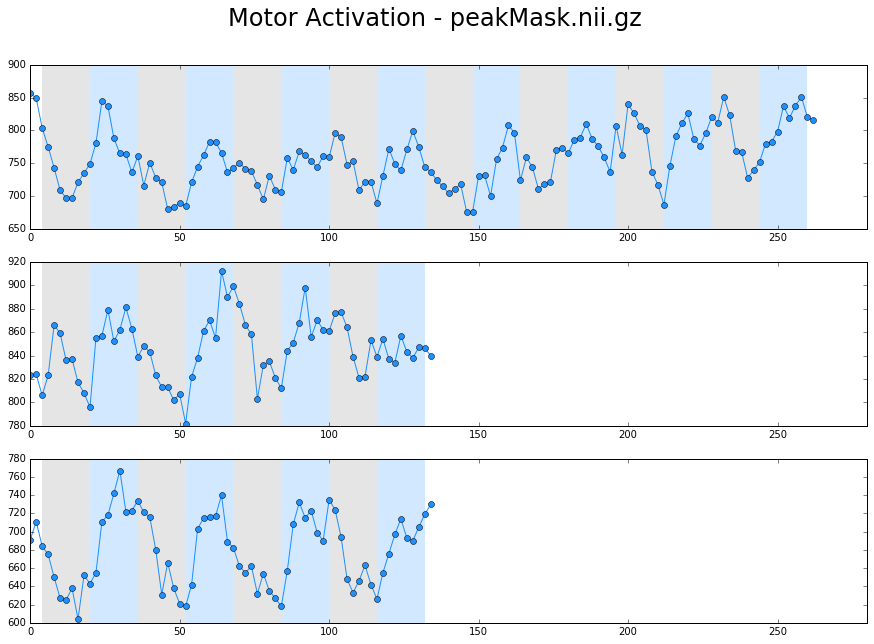

In [65]:
plotRaw(join(rtDir, 'peakMask.nii.gz'), 'motor')

### 5mm Sphere around peak

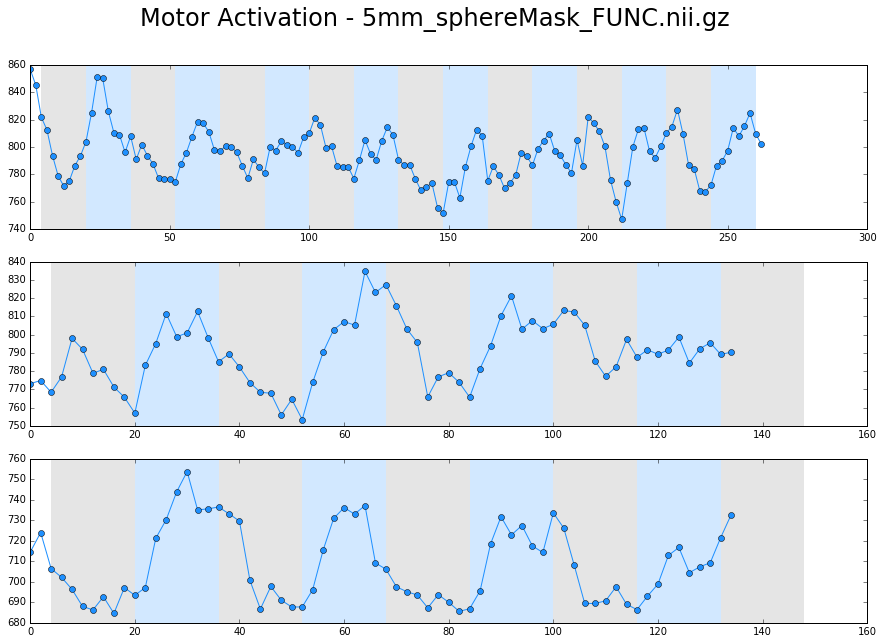

In [53]:
plotRaw(join(rtDir, '5mm_sphereMask_FUNC.nii.gz'), 'motor')

### whole brain mask

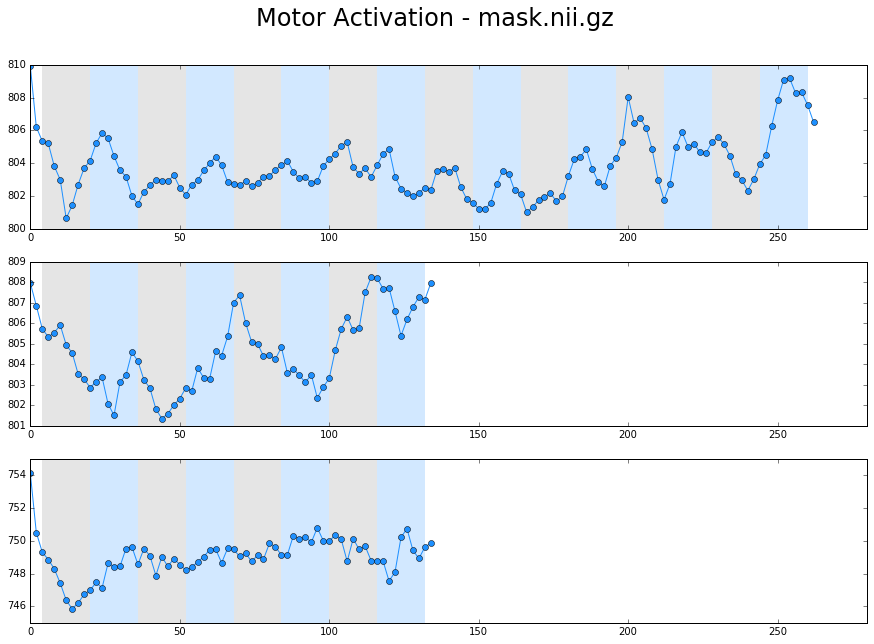

In [66]:
plotRaw(join(rtDir, 'firstLevel+.feat/mask.nii.gz'), 'motor')

## Train & Test Classifier

In [68]:
import pickle

from nilearn.input_data import NiftiMasker
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [173]:
def buildClassifier(funcFile, maskFile, labelsFile):
    """ Train a classifier on the specified funcFile
    
    classifier will be trained using voxels found in maskFile. Timepts
    labeled according to labelsFile
    """
    # set up masker to mask and standardize input data
    masker = NiftiMasker(mask_img=maskFile, standardize=True)

    # load fMRI, apply masker
    fmri = masker.fit_transform(funcFile)
    
    # create mask to isolate conditions of interest
    labels = pd.read_table(labelsFile, header=None, squeeze=True)
    conditions_mask = labels.isin(['Rest', 'Active'])
    
    # mask fmri timepts
    fmri = fmri[conditions_mask]
    
    # mask labels
    labels = labels[conditions_mask]
    
    # build the classifier object
    clf = SVC(kernel='linear', C=100, probability=True)
    
    # see how classifier performs through cross validation
    cv = KFold(n_splits=5)
    cv_score = cross_val_score(clf, fmri, labels, cv=cv)
    print('TRAIN: mean crossval acc: {}, stdDev: {}'.format(np.mean(cv_score), np.std(cv_score)))
    
    # retrain classifier using full run, return
    clf.fit(fmri, labels)
    return clf


def applyClassifier(funcFile, maskFile, clf):
    """ Apply the given classifier to the given funcFile.
    
    To mimic the behavior during a real-time scan, we will iterate through each 
    timept in the func series. At each timept, we will standardize the data
    UP TO THAT TMPOINT, and then classify the current timept. 
    
    Ouputs probability of 'Active' for each timept
    """
    # get the index if 'active' class from classifier
    activeIdx = np.where(clf.classes_ == 'Active')[0][0]
    
    
    
    # load mask & fmri
    mask = nib.load(maskFile).get_data().astype('bool')
    fmri = nib.load(funcFile).get_data()
    
    # mask fmri to get nSamples x nVoxels array
    masked_fmri = np.zeros(shape=(fmri.shape[3], sum(mask.ravel())))
    for t in range(fmri.shape[3]):
        thisVol = fmri[:, :, :, t]
        maskedVol = thisVol[mask]
        
        masked_fmri[t,:] = maskedVol
        
    # empty vars to store predicted class and probability
    predictedClass = []
    predictedProb = []
    
    # iterate over every timept in the series
    for sampleIdx in range(masked_fmri.shape[0]):
        
        # standardize voxel timeseries on all datapoints up to the current one
        theseSamples = masked_fmri[:sampleIdx+1, :]
        std_fmri = standardizeTimeseries(theseSamples)
        
        # grab current timept, reshape to (1, nFeatures)
        sample = std_fmri[sampleIdx, :].reshape(1, masked_fmri.shape[1])
        
        # predict the class & get probability
        predictedClass.append(clf.predict(sample)[0])
        predictedProb.append(clf.predict_proba(sample)[activeIdx][0])
    
    return np.array(predictedClass), np.array(predictedProb)
        
        
def standardizeTimeseries(signals):
    """
    'signals' expected to be a 2D array of timeseries with time on the first
    axis (rows) and voxels on the second axis (columns). This method will
    mean center each voxel, and set the variance to 1.

    returns a standardized array of the same dimensions

    Note: these calculations taken from 'clean' method from signal.py in
    the nilearn packagage:
    https://github.com/nilearn/nilearn/blob/master/nilearn/signal.py
    """
    signals = signals - signals.mean(axis=0)   # remove mean
    std = np.sqrt((signals**2).sum(axis=0))
    std[std < np.finfo(np.float).eps] = 1.  # avoids numerical problems
    signals /= std    # divide every value in signals by the std
    signals *= np.sqrt(signals.shape[0])  # set unit variance (i.e. 1)

    return signals  
    

In [220]:
funcFile = join(rtDir, 'func_0000.nii.gz')
maskFile = join(rtDir, '5mm_sphereMask_FUNC.nii.gz')
labelsFile = join(rtDir, 'timingFiles/fullRunLabels_excl2.txt')

clf = buildClassifier(funcFile, maskFile, labelsFile)
pc, pp = applyClassifier(funcFile, maskFile, clf)

TRAIN: mean crossval acc: 0.7389473684210527, stdDev: 0.06834813928735971


In [299]:
# Tools for assessing classifier performance

def printClassifierResults(maskFile, trainLabelsFile, trainFunc, testFunc1, testFunc2, taskType):
    """ Build a classifier off training run. Apply to rest runs. Print Results """
    # build the classifier
    clf = buildClassifier(trainFunc, maskFile, trainLabelsFile)
    
    # apply the classifier
    train_pc, train_pp = applyClassifier(trainFunc, maskFile, clf)
    test1_pc, test1_pp = applyClassifier(testFunc1, maskFile, clf)
    test2_pc, test2_pp = applyClassifier(testFunc2, maskFile, clf)
    
    # build the correctLabels for train run and test run
    correctLabels_train = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*8 + ['Rest', 'Rest'])
    correctLabels_test = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*4 + ['Rest', 'Rest'])
    
    # print applied classification accuracy
    print('Test 1: accuracy {}'.format(sum(correctLabels_test == test1_pc)/len(correctLabels_test)))
    print('Test 2: accuracy {}'.format(sum(correctLabels_test == test2_pc)/len(correctLabels_test)))
    

def plotClassifierResults(maskFile, trainLabelsFile, trainFunc, testFunc1, testFunc2, taskType):
    """ Build a classifier based off training run. Apply to test runs. Plot results
    
    All analyses will be confined to the voxels in specified mask file. Classification
    will be based on labels in the labelsFile
    """
    # build the classifier
    clf = buildClassifier(trainFunc, maskFile, trainLabelsFile)
    
    # start the plot
    plt.figure(figsize=(15,10))
    plt.suptitle('{} - {}'.format(taskType.capitalize(), os.path.split(maskFile)[-1]), fontsize=24)
    
    # set colors
    if taskType == 'finger-tapping':
        taskColor = 'dodgerBlue'
    elif taskType == 'imagery':
        taskColor = 'goldenrod'

    # load the mask
    mask = nib.load(maskFile)
    
    # trial times 
    restOnsets = np.array([(x*32)+4 for x in range(8)]) 
    activeOnsets = restOnsets + 16
    
    axs = []
    for i,run in enumerate([trainFunc, testFunc1, testFunc2]):
        
        # apply the classifier
        predictedClass, predictedProb = applyClassifier(run, maskFile, clf)
        
        # build the correctLabels for each timept
        if predictedClass.shape[0] == 132:
            # long run
            timeptLabels = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*8 + ['Rest', 'Rest'])
        else:
            # short run
            timeptLabels = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*4 + ['Rest', 'Rest'])

        # build an array of correctly predicted timepts
        isCorrectPredicted = timeptLabels == predictedClass
        
        thisAx = plt.subplot(int('31'+(str(i+1))))
        thisAx_prob = thisAx.twinx()
        axs.append(thisAx)
        axs.append(thisAx_prob)
        
        # load masked data, get meanTS
        maskedData = apply_mask(run, mask)
        meanTS = np.mean(maskedData, axis=1)
        
        # set x
        x = np.arange(0, maskedData.shape[0]*2, 2)
        
        # plot meanTS
        thisAx.plot(x, meanTS, color='k', ls='--', alpha=.4)
        thisAx.set_xlim(0,280)
        
        # plot classification prob
        thisAx_prob.plot(x, predictedProb, '-', color=taskColor)
        thisAx_prob.set_ylim(-.1,1.1)
        
        # plot classification class
        isActiveLabel = timeptLabels == 'Active'
        correctActiveTimepts = np.logical_and(isCorrectPredicted, isActiveLabel)
        thisAx_prob.scatter(x[correctActiveTimepts], np.ones(sum(correctActiveTimepts)), color=taskColor, s=30)
        
        isRestLabel = timeptLabels == 'Rest'
        correctRestTimepts = np.logical_and(isCorrectPredicted, isRestLabel)
        thisAx_prob.scatter(x[correctRestTimepts], np.zeros(sum(correctRestTimepts)), color='grey', s=30)
        
        # plot 50% prob line
        thisAx_prob.axhline(y=.5, ls='-.', color='r')
        
        # plot trial spans
        for r in restOnsets:
            thisAx.axvspan(r, r+16, facecolor='gray', edgecolor='none', alpha=0.2)
        for a in activeOnsets:
            thisAx.axvspan(a, a+16, facecolor=taskColor, edgecolor='none', alpha=0.2)
    
    


TRAIN: mean crossval acc: 0.7389473684210527, stdDev: 0.06834813928735971


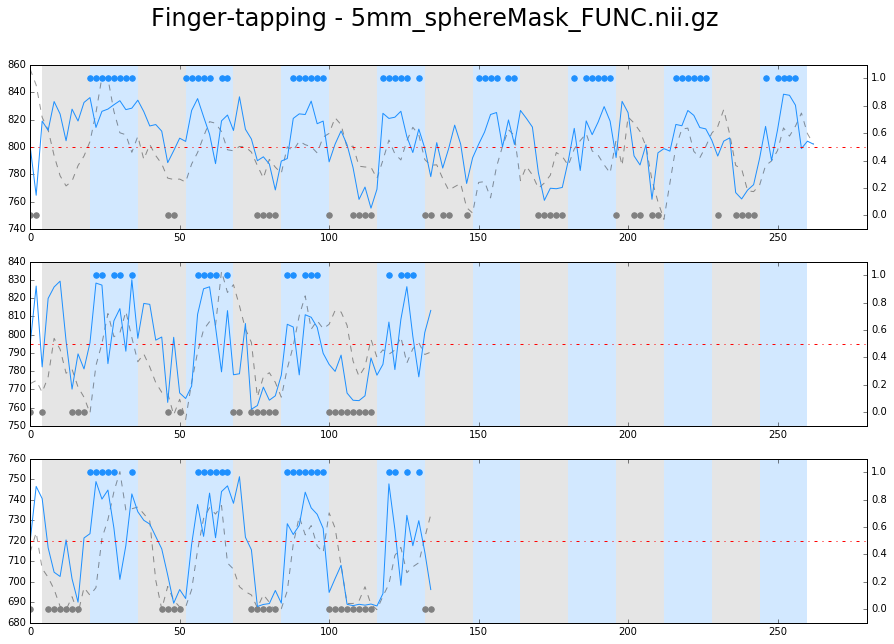

In [300]:
trainRun = join(rtDir, 'func_0000.nii.gz')
testRun1 = join(rtDir, 'func_0001.nii.gz')
testRun2 = join(rtDir, 'func_0002.nii.gz')
maskFile = join(rtDir, '5mm_sphereMask_FUNC.nii.gz')
labelsFile = join(rtDir, 'timingFiles/fullRunLabels_excl2.txt')

plotClassifierResults(maskFile, labelsFile, trainRun, testRun1, testRun2, 'finger-tapping')

TRAIN: mean crossval acc: 0.6473684210526315, stdDev: 0.19093007523386374


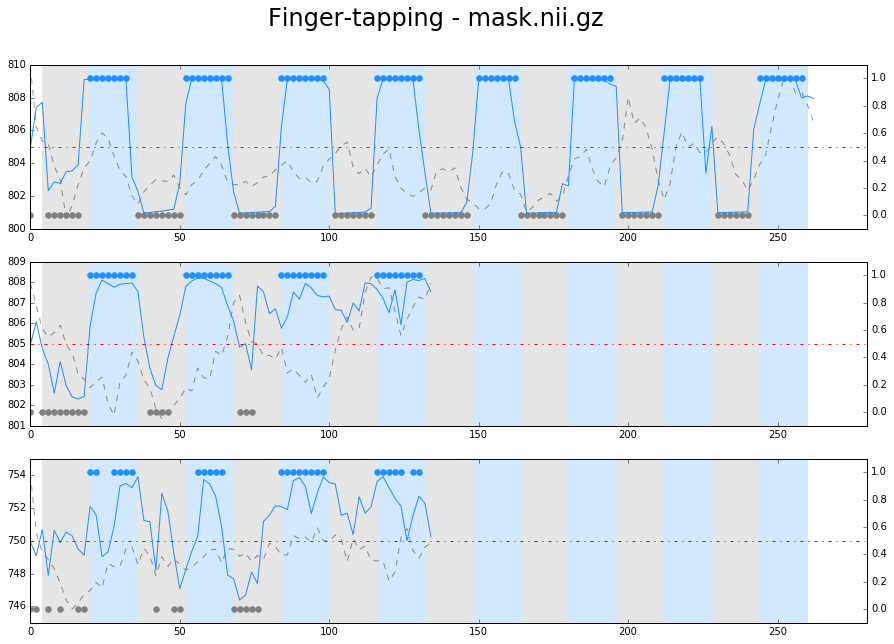

In [301]:
trainRun = join(rtDir, 'func_0000.nii.gz')
testRun1 = join(rtDir, 'func_0001.nii.gz')
testRun2 = join(rtDir, 'func_0002.nii.gz')
maskFile = join(rtDir, 'firstLevel+.feat/mask.nii.gz')
labelsFile = join(rtDir, 'timingFiles/fullRunLabels_excl2.txt')

plotClassifierResults(maskFile, labelsFile, trainRun, testRun1, testRun2, 'finger-tapping')

TRAIN: mean crossval acc: 0.6473684210526315, stdDev: 0.19093007523386374
TRAIN: mean crossval acc: 0.7389473684210527, stdDev: 0.06834813928735971
TRAIN: mean crossval acc: 0.8010526315789473, stdDev: 0.12712024538484654
TRAIN: mean crossval acc: 0.6542105263157895, stdDev: 0.1669309077967269
TRAIN: mean crossval acc: 0.7694736842105263, stdDev: 0.17564759480939918
TRAIN: mean crossval acc: 0.8021052631578949, stdDev: 0.14269274276067825


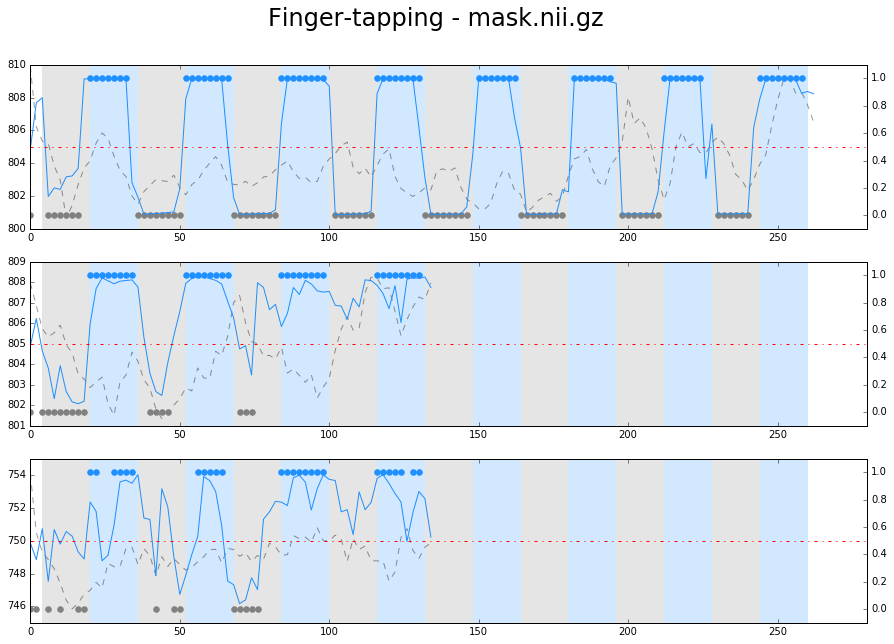

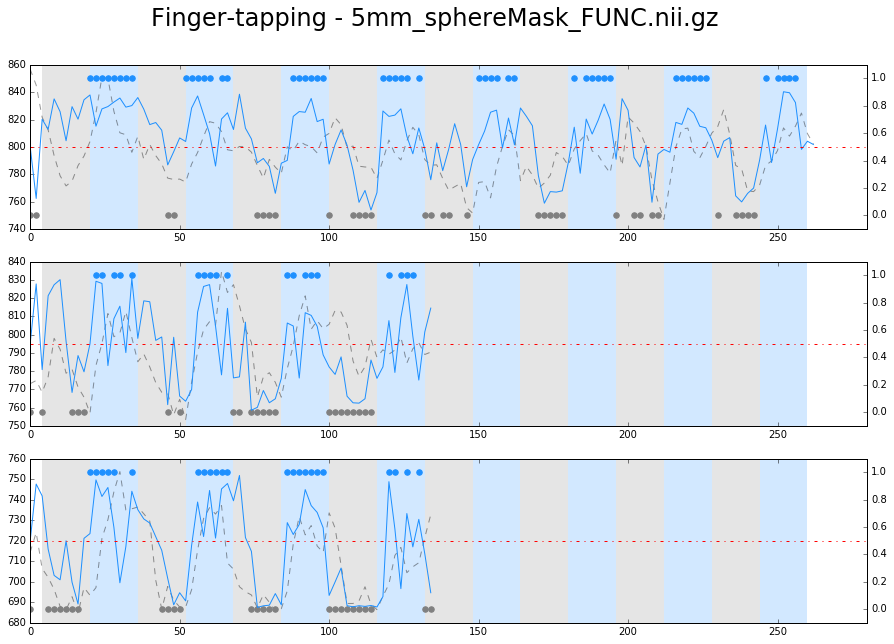

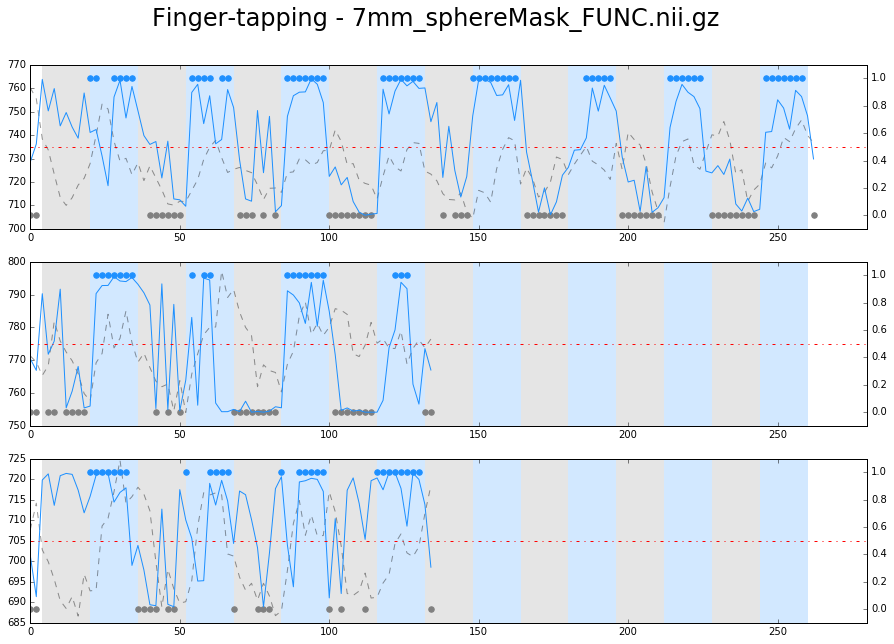

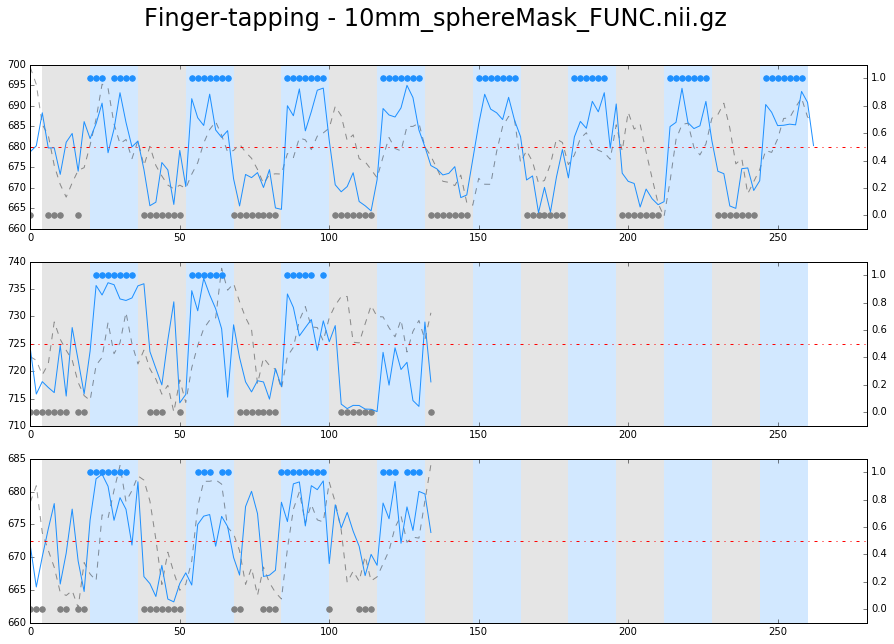

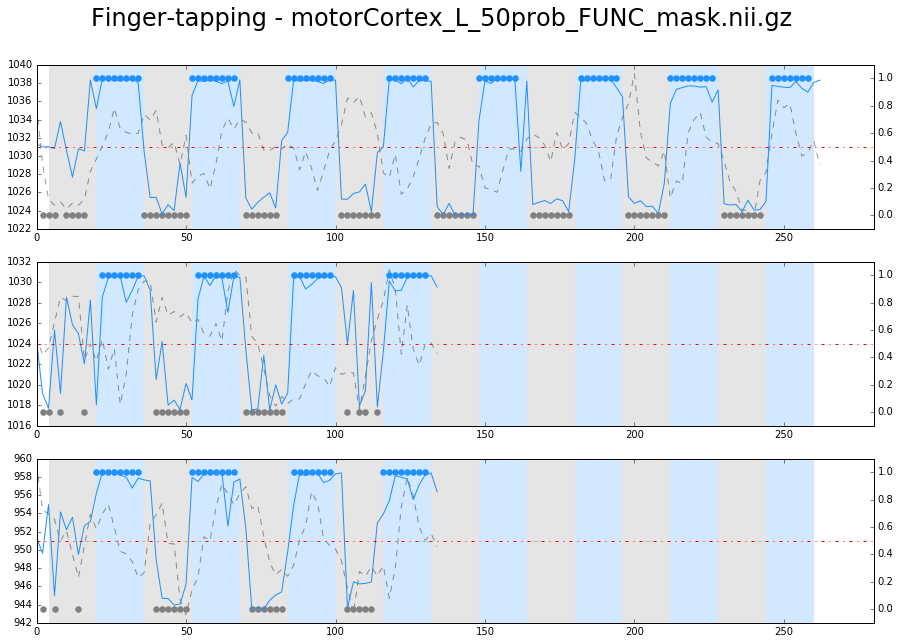

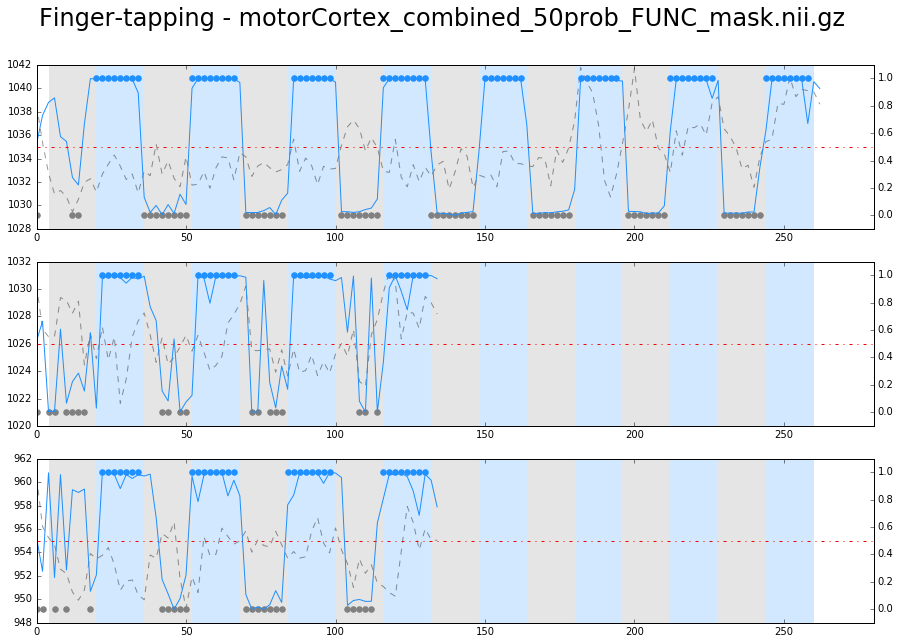

In [302]:
trainRun = join(rtDir, 'func_0000.nii.gz')
testRun1 = join(rtDir, 'func_0001.nii.gz')
testRun2 = join(rtDir, 'func_0002.nii.gz')
labelsFile = join(rtDir, 'timingFiles/fullRunLabels_excl2.txt')

masks = ['firstLevel+.feat/mask.nii.gz',
         '5mm_sphereMask_FUNC.nii.gz', 
         '7mm_sphereMask_FUNC.nii.gz', 
         '10mm_sphereMask_FUNC.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_L_50prob_FUNC_mask.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_combined_50prob_FUNC_mask.nii.gz']

for mask in masks:
    maskFile = join(rtDir, mask)
    plotClassifierResults(maskFile, labelsFile, trainRun, testRun1, testRun2, 'finger-tapping')